# MLPS - Mercari Price ML

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')  # prettier plots
import seaborn as sns; sns.set()

import pandas as pd 
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import json 
import operator
import copy
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import load_npz, save_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso

from nltk.stem.porter import *
import string

sd_out = 6
log_trans = 0.000000001

### Load data

In [3]:
# load data 
data = pd.read_csv("Data/train.tsv", delimiter="\t", index_col=0)

### Perform data cleaning

In [4]:
# remove items with out a price
data = data[pd.notna(data["price"])]

# remove outliers
data['log_price'] = np.log(data['price'] + log_trans)
st_dev_log_price_6 = data['log_price'].std()*sd_out
out = np.array((data['log_price'] < st_dev_log_price_6) & 
               (data['log_price'] > -st_dev_log_price_6))
data = data[out]
data.reset_index(drop = True, inplace=True)
data.drop(columns=["log_price"], inplace=True)

#replace null brand with no brand info
data["brand_name"][data["brand_name"].isnull()] = "No Brand Info"

# replace no descriptions with "" to avoid no descript yet
data["item_description"] = data["item_description"].replace("No description yet", "")
data["item_description"] = data["item_description"].replace(np.nan, "")

# split out category
temp = data["category_name"].fillna('').str.split('/')        
data["category_name_1"] = temp.str[0]
data["category_name_2"] = temp.str[1]
data["category_name_3"] = temp.str[2:].str.join("/")

### Implement porter stemming in count vectorizer

In [15]:
class StemmerTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()
        self.translator = str.maketrans('', '', string.punctuation + string.digits)
        self.ps_dict = dict()
    def __call__(self, doc):
        output = []
        for w in doc.encode('ascii', errors='ignore').decode('ascii').translate(self.translator).split():
            stem = self.ps.stem(w)
            self.ps_dict.setdefault(stem,set()).add(w)
            output.append(stem)
        return output

stemmer = StemmerTokenizer()
    
vectorizer = CountVectorizer(lowercase = True,
                             max_df = .5,
                             min_df = .001,
                             tokenizer = stemmer,
                             stop_words='english')

### Count vectorize the data

In [16]:
%%time
tfm = vectorizer.fit_transform(data["item_description"])

Wall time: 14min 21s


In [17]:
%%time
tfidf_vectorizer = TfidfTransformer()
tfidf_transformed = tfidf_vectorizer.fit_transform(tfm)

Wall time: 948 ms


### For saving results

In [37]:
save_npz("tfm.npz", tfm)
save_npz("tfidf_transformed.npz", tfidf_transformed)

In [38]:
with open("vocabulary.txt", "w") as f:
    f.write("".join([k + '\n' for k, v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]))

In [39]:
with open("porter_dictionary.json", "w") as f:
    f.write(json.dumps({k: list(v) for k, v in stemmer.ps_dict.items()}))

In [90]:
data.to_csv("train_clean.csv")

### For loading the data

In [86]:
tfm = load_npz("tfm.npz")
tfidf_transformed = load_npz("tfidf_transformed.npz")

In [87]:
with open("vocabulary.txt", 'r') as f:
    vocabulary = f.read().split('\n')

In [88]:
with open("porter_dictionary.json", 'r') as f:
    ps_dict = json.loads(f.read())

In [92]:
data = pd.read_csv("train_clean.csv")

## Split into train and test

In [98]:
cleaned_categorical = data

y_categorical = cleaned_categorical['price']
cleaned_categorical.drop(["name","category_name","item_description","price"], axis=1, inplace=True)
cleaned_categorical["item_condition_id"] = cleaned_categorical["item_condition_id"].astype('str', copy=False)

ohe_cleaned_categorical = pd.get_dummies(cleaned_categorical)

n_sample = 100000
sample = np.random.permutation(y_categorical.shape[0])[:n_sample]

y_categorical_sample = y_categorical[sample]
ohe_cleaned_categorical_sample = ohe_cleaned_categorical.iloc[sample]
tfidf_transformed_sample = tfidf_transformed[sample]

ohe_cleaned_categorical_sample.reset_index(drop = True, inplace = True);
y_categorical_sample.reset_index(drop = True, inplace = True);

In [14]:
# split into train and test
yTrain, yTest, XTrain, XTest, tfidfTrain, tfidfTest = train_test_split(
    y_categorical_sample, ohe_cleaned_categorical_sample, tfidf_transformed_sample, test_size=0.3, random_state=95)

yTrain.reset_index(drop = True, inplace = True)
yTest.reset_index(drop = True, inplace = True)
XTrain.reset_index(drop = True, inplace = True)
XTest.reset_index(drop = True, inplace = True);

In [ ]:
%time
# specify number of folds
folds = 2
kf = KFold(n_splits=folds)

# Test train and validate
alpha_values = [0.001, 0.01, 0.1, 1]
alpha_inner_values = [0.01, 0.001]
from sklearn.linear_model import Lasso
import copy

mseOuterTrain = []
mseOuterVal = []
mseInnerTrain = []
mseInnerVal = []
mseOverallTrain = []
mseOverallVal= []

for i, (train_index, val_index) in enumerate(kf.split(yTrain)):
    print(i)
    yTrain_fold = yTrain.iloc[train_index]
    yVal_fold = yTrain.iloc[val_index]

    XTrain_fold = XTrain.iloc[train_index]
    XVal_fold = XTrain.iloc[val_index]
    
    tfidfTrain_fold = tfidfTrain[train_index]
    tfidfVal_fold = tfidfTrain[val_index]
    

    for a_outer in alpha_values:
        print(i, a_outer)
        lasso = Lasso(alpha=a_outer, random_state=111, max_iter=1000).fit(XTrain_fold, yTrain_fold)
        predict_train = lasso.predict(XTrain_fold)
        train_residuals = yTrain_fold - predict_train
        mseOuterTrain.append(copy.deepcopy((i, None, a_outer ,None, np.square(train_residuals).mean())))
        
        predict_val = lasso.predict(XVal_fold)
        val_residuals = yVal_fold - predict_val
        mseOuterVal.append(copy.deepcopy((i, None, a_outer , None, np.square(val_residuals).mean())))
        
        for a_inner in alpha_inner_values:
            print(j, a_outer, a_inner)
            lasso_inner = Lasso(alpha=a_inner, random_state=111, max_iter=1000).fit(tfidfTrain_fold, train_residuals)
            predict_inner_train = lasso_inner.predict(tfidfTrain_fold)
            inner_train_residuals = train_residuals - predict_inner_train
            mseInnerTrain.append(copy.deepcopy((i, j, a_inner, np.square(inner_train_residuals).mean())))

            predict_inner_val = lasso_inner.predict(tfidfVal_fold)
            inner_val_residuals = val_residuals - predict_inner_val
            mseInnerVal.append(copy.deepcopy((i, j, a_inner, np.square(inner_val_residuals).mean())))

            residuals_overall_train = yTrain_fold - predict_train - predict_inner_train
            mseOverallTrain.append(copy.deepcopy((i, j, a_outer, a_inner, np.square(residuals_overall_train).mean())))

            residuals_overall_val = yVal_fold - predict_val - predict_inner_val
            mseOverallVal.append(copy.deepcopy((i, j, a_outer, a_inner, np.square(residuals_overall_val).mean())))
    

In [ ]:
import operator
sorted(mseOverallVal, key = operator.itemgetter(4))

In [ ]:
import operator
sorted(mseOuterVal, key = operator.itemgetter(4))

### LASSO Model Validation

In [ ]:
lasso = Lasso(alpha=0.01, random_state=111, max_iter=1000).fit(XTrain, yTrain)
pred = lasso.predict(XTrain)
lasso.score(XTrain, yTrain)

lasso_res = Lasso(alpha=0.0001, random_state=111, max_iter=1000).fit(tfidfTrain, (pred - yTrain))
pred_res = lasso_res.predict(tfidfTrain)
lasso_res.score(tfidfTrain, (pred - yTrain))

pred_res = lasso_res.predict(tfidfTrain)
pred_plus = pred + pred_res
plt.scatter(yTrain, pred - yTrain, c= "r")
plt.scatter(yTrain, pred_plus, c = "b")

## Build Heatmap for MSE

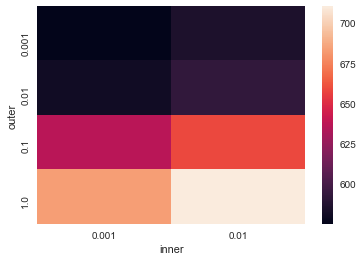

In [80]:
grouped = test.groupby(["outer","inner"]).mean()
grouped.drop(columns=["fold1", "fold2"], inplace=True)
grouped.reset_index(inplace=True)
grouped
fin = grouped.pivot("outer", "inner", "MSE")
ax = sns.heatmap(fin)

### Analysis Plots on Stemming Process

7199


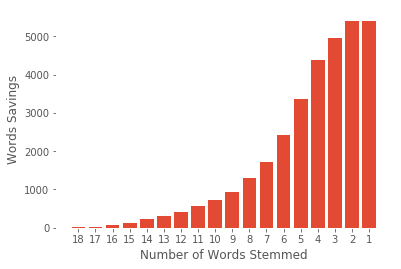

In [53]:
tuples = [(k, len(v)) for k, v in ps_dict.items()]
freq = {}
for k, v in sorted(tuples, key=operator.itemgetter(1), reverse=True):
    if k in vocabulary:
        if (v in freq.keys()):
            freq[v] += 1
        else:
            freq[v] = 1

x, y = zip(*freq.items())

x = np.array(x)
y = np.array(y)
cum = ((x*y) - y).cumsum()

plt.bar(x, cum)

ax = plt.gca()
ax.invert_xaxis()
ax.set_facecolor('white')
plt.xlabel("Number of Words Stemmed")
plt.ylabel("Words Savings")
plt.xticks(x)
plt.grid(False)

# final predictions on Test and Train

In [ ]:
lasso = Lasso(alpha=0.001, random_state=111, max_iter=1000).fit(XTrain, yTrain)
pred = lasso.predict(XTrain)
lasso.score(XTrain, yTrain)

In [ ]:
lasso_res = Lasso(alpha=0.001, random_state=111, max_iter=1000).fit(tfidfTrain, (pred - yTrain))
pred_res = lasso_res.predict(tfidfTrain)
lasso_res.score(tfidfTrain, (pred - yTrain))

pred = lasso.predict(XTrain)
pred_res = lasso_res.predict(tfidfTrain)
print(np.square(yTrain - pred - pred_res).mean())

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.scatter(yTrain, yTrain-pred, c= "r", label = "Stage1")
plt.scatter(yTrain, yTrain-pred - pred_res, c = "b", label = "Stage1 & Stage2")
plt.legend()
plt.xlabel("Price")
plt.xlabel("Residuals")
plt.savefig("moneygraph.png")